In [0]:
# перезагрузить ноутбук
!kill -9 -1

# Разделение аудиопотока (фразы) на отдельные слова 

Копирование файлов с Git на локальный диск виртуальной машины - вставка ссылки с гитхаба: 

In [2]:
!git clone https://github.com/smartsinovich/Simple-Audio-Recognition.git

fatal: destination path 'Simple-Audio-Recognition' already exists and is not an empty directory.


In [3]:
!pip install soundfile

In [4]:
!pip install pydub



---



In [0]:
import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline
import soundfile as sf
from scipy.io import wavfile
import scipy.io.wavfile

import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

import soundfile as sf
from scipy.io import wavfile
import scipy.io.wavfile
import matplotlib.pyplot as plt




Загружаем файл аудиопотока для дальнейшей обработки из директория Seg_audio_streams

Это файл с сильно уменьшенным количеством данных. Он нужен только для определения точек разреза.

Также загружаем из директория Audio_streams оригинальную (необработанную фразу) и путь к ней.  Ее будем резать по определенным точкам разреза. 

/content/Simple-Audio-Recognition/Seg_audio_streams/seg_bed_bird_right.wav
samples = 120   sample rate = 40   seconds = 3.0
40 [     0     -8      0      0      0      0      1      0     -8  -6978
   1495  -8190 -11298  -1186   -206   2408   3879    456    478   -377
    -38    -83      0      8      0      0     -4      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      1     -5      0      4    -13     -9      2     -2
     26   2486  -6386   7039   7189   1986  -5409  -2452  -4377   2016
   1257   2213    921    305     -2      0     41      3      0      0
      0      1      2      0      0      0      0      0      0      0
      0      0      0      0      1      0      0      0    103    414
    240     34   -496    434  -2150   -696    828     53     44     48
      0      0      0      6      7      0      5      0      0      4
      0      0      0      0      0      0      0      0      0      0]


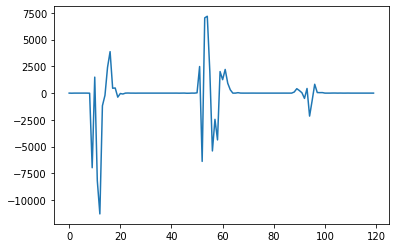

In [62]:
#__________- файлы из директория  Seg_audio_streams. нужны для построения разрезания фразы на упрощенном аудиопотоке

segmented_file = '/content/Simple-Audio-Recognition/Seg_audio_streams/seg_bed_bird_right.wav'
#segmented_file = '/content/Simple-Audio-Recognition/Seg_audio_streams/seg_no_bed_bird.wav'

#_____________ оригинальная фраза для разрезания и откуда берется фраза для разрезания
sample_file ='bed_bird_right.wav'
dir_path = '/content/Simple-Audio-Recognition/Audio_streams/' #  откуда берется оригинальная фраза



print(segmented_file)
f = sf.SoundFile(segmented_file)
print('samples = {}'.format(len(f)), '  sample rate = {}'.format(f.samplerate), '  seconds = {}'.format(len(f) / f.samplerate))
rate, data = scipy.io.wavfile.read(segmented_file)
print(rate, data)
plt.plot(data)
plt.show()

Выполним ряд преобразований.

Цель: 

1.   Избавиться от шума - выделить моменты тишины
2.   Определить середины периодов тишины для последующего разрезания аудиопотока



In [63]:
a = np.array(data)
sound = a.copy()
print(a)
print(sound)


[     0     -8      0      0      0      0      1      0     -8  -6978
   1495  -8190 -11298  -1186   -206   2408   3879    456    478   -377
    -38    -83      0      8      0      0     -4      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      1     -5      0      4    -13     -9      2     -2
     26   2486  -6386   7039   7189   1986  -5409  -2452  -4377   2016
   1257   2213    921    305     -2      0     41      3      0      0
      0      1      2      0      0      0      0      0      0      0
      0      0      0      0      1      0      0      0    103    414
    240     34   -496    434  -2150   -696    828     53     44     48
      0      0      0      6      7      0      5      0      0      4
      0      0      0      0      0      0      0      0      0      0]
[     0     -8      0      0      0      0      1      0     -8  -6978
   1495  -8190 -11298  -1186   -206   2408   3879    456    478   -377
    -

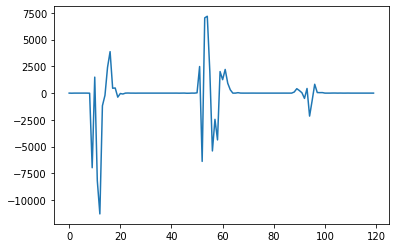

In [64]:
plt.plot(a)
plt.show()

In [65]:
abs_a = np.abs(a)
abs_a

array([    0,     8,     0,     0,     0,     0,     1,     0,     8,
        6978,  1495,  8190, 11298,  1186,   206,  2408,  3879,   456,
         478,   377,    38,    83,     0,     8,     0,     0,     4,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     1,     5,     0,
           4,    13,     9,     2,     2,    26,  2486,  6386,  7039,
        7189,  1986,  5409,  2452,  4377,  2016,  1257,  2213,   921,
         305,     2,     0,    41,     3,     0,     0,     0,     1,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     1,     0,     0,     0,   103,   414,
         240,    34,   496,   434,  2150,   696,   828,    53,    44,
          48,     0,     0,     0,     6,     7,     0,     5,     0,
           0,     4,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int16)

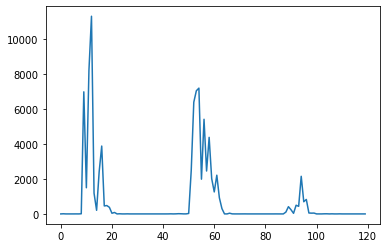

In [66]:
plt.plot(abs_a)
plt.show()

In [67]:
porog = 50 # порог чтобы срезать шум
b = abs_a.clip(porog, abs_a.max())
b

array([   50,    50,    50,    50,    50,    50,    50,    50,    50,
        6978,  1495,  8190, 11298,  1186,   206,  2408,  3879,   456,
         478,   377,    50,    83,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,  2486,  6386,  7039,
        7189,  1986,  5409,  2452,  4377,  2016,  1257,  2213,   921,
         305,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,   103,   414,
         240,    50,   496,   434,  2150,   696,   828,    53,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50], dtype=int16)

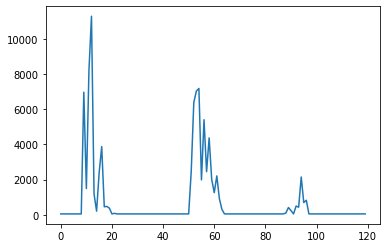

In [68]:
plt.plot(b)
plt.show()

In [69]:
# создадим такой же массив, заполним его одинаковыми элементами
c = b.copy()
c

array([   50,    50,    50,    50,    50,    50,    50,    50,    50,
        6978,  1495,  8190, 11298,  1186,   206,  2408,  3879,   456,
         478,   377,    50,    83,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,  2486,  6386,  7039,
        7189,  1986,  5409,  2452,  4377,  2016,  1257,  2213,   921,
         305,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,   103,   414,
         240,    50,   496,   434,  2150,   696,   828,    53,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50], dtype=int16)

In [70]:
c.fill(porog)
c

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50], dtype=int16)

In [71]:
d = b - c
d

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
        6928,  1445,  8140, 11248,  1136,   156,  2358,  3829,   406,
         428,   327,     0,    33,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,  2436,  6336,  6989,
        7139,  1936,  5359,  2402,  4327,  1966,  1207,  2163,   871,
         255,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,    53,   364,
         190,     0,   446,   384,  2100,   646,   778,     3,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int16)

In [72]:
e = d.clip(0, 1)
e

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

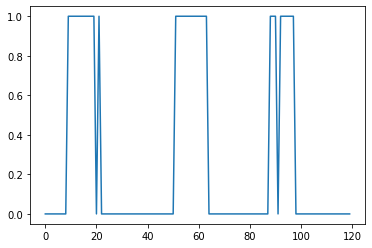

In [73]:
plt.plot(e)
plt.show()



---



# Определяем координаты центров тишины. 
Эти координаты будут использованы для разрезания аудиопотока на части - фразу делим на слова



---



---



---



In [0]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], int)



In [75]:
a = e.copy()
a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

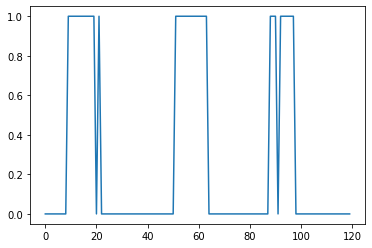

In [76]:
plt.plot(a)
plt.show()

Решение берем отсюда: https://younglinux.info/python/task/id-range

In [77]:

#def my_function(a): # задаем массив
   
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1

  
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list = []
sound_center_list.append(sound_center_i)
print(sound_center_list)


Количество элементов:  13
id первого элемента:  51
id последнего элемента:  63
середина 56
56
[56]


In [78]:
a[index-max_count+1:index] # items start through end-1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16)

ОБнуляем полученное единички. ищем следущую самую длинную последовательность единичек

In [0]:

a[index-max_count+1:index] = 0 #ОБнуляем полученное единички. 

In [0]:
a1 = a


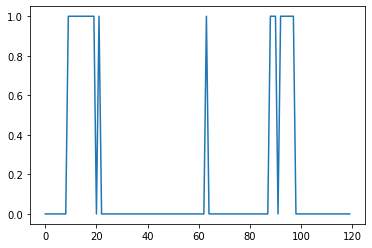

In [81]:
plt.plot(a1)
plt.show()

In [0]:
a2 = a1.copy()
a = a2

In [83]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list.append(sound_center_i)
print(sound_center_list)


Количество элементов:  11
id первого элемента:  9
id последнего элемента:  19
середина 14
14
[56, 14]


In [0]:
a[index-max_count+1:index] = 0 #ОБнуляем полученное единички. 

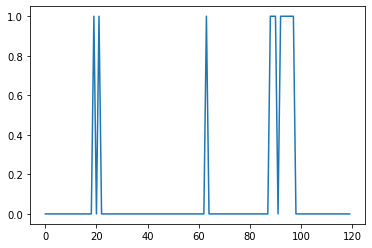

In [85]:
plt.plot(a)
plt.show()

In [0]:
# делаем копию и запускаем снова
a3 = a.copy()
a = a3

In [87]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list.append(sound_center_i)
print(sound_center_list)

Количество элементов:  6
id первого элемента:  92
id последнего элемента:  97
середина 94
94
[56, 14, 94]


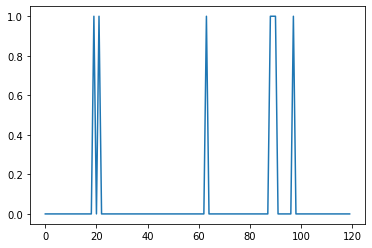

In [88]:
a[index-max_count+1:index] = 0 #ОБнуляем полученное единички.
# делаем копию и запускаем снова
a4 = a.copy()
a = a4
plt.plot(a)
plt.show()

In [89]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))

Количество элементов:  3
id первого элемента:  88
id последнего элемента:  90
середина 88




---



у нас периоды звука не сильно отличаются друг от друга.

Длина звука - это в нашем случае количество элементов.
Звуки 1, 2, 3 имеют 14 индексов (количество элементов), а звук 4 - 1 элемент. 
Это означает, что более или менее длиные звуки кончились. 
Можем воспользоваться этим как сигналом для остановки поиска новых слов во фразе.
Если отношение (количество элементов для первого звука / количеств элементов следующего звука) > 2, то функцию поиска середины звука останавливаем

ИТОГО получили три индекса - центры звуков. 
C1 = середина 54.5
C2 = середина 14.0
C3 = середина 87.0

Будем искать линии разрезов
Первый разрез T0 = 0


In [90]:
C1 = 54 # взято для примера, обработка файла 'seg_no_bed_bird.wav'
C2 = 14
C3 = 87

Center_list  = sound_center_list
print(Center_list)

# ранжируем список центров звука по возростанию
Center_list.sort()
b = sorted(Center_list)
print(b)
print(range(len(b)))

T0 = 0
T1 = b[0]
T2 = b[1]
T3 = b[2]


[56, 14, 94]
[14, 56, 94]
range(0, 3)


Вычисляем точки разреза:

In [91]:
# для фразы из трех слов - это две точки, для фразы из трех слов - две.
# для файла 'seg_no_bed_bird.wav' - две точки.

S1 = round(T0 + (T1-T0)/2)
S1 = round(T1 + (T2-T1)/2)
S2 = round(T2 + (T3-T2)/2)

print(S1 )
print(S2)

Split_list = [S1, S2]
print(Split_list) 

t0 = 0
t1 = Split_list[0]
t2 = Split_list[1]
print(t0, t1, t2)
print(t1)
print

#34,70

35
75
[35, 75]
0 35 75
35


<function print>

In [92]:
#sound = np.array(data)
sound

array([     0,     -8,      0,      0,      0,      0,      1,      0,
           -8,  -6978,   1495,  -8190, -11298,  -1186,   -206,   2408,
         3879,    456,    478,   -377,    -38,    -83,      0,      8,
            0,      0,     -4,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      1,     -5,      0,      4,    -13,     -9,
            2,     -2,     26,   2486,  -6386,   7039,   7189,   1986,
        -5409,  -2452,  -4377,   2016,   1257,   2213,    921,    305,
           -2,      0,     41,      3,      0,      0,      0,      1,
            2,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      1,      0,      0,      0,
          103,    414,    240,     34,   -496,    434,  -2150,   -696,
          828,     53,     44,     48,      0,      0,      0,      6,
            7,      0,      5,      0,      0,      4,      0,      0,
      

In [0]:
sound = np.array([     0,      0,      0,      0,      0,      0,      0,    117,
          861,   -268,    509,   3850,   1405,   1119,  -2602,    213,
        1192,  -3022,   -337,  -1292,  -5351,   1128,    123,   1034,
         -167,   -309,     22,      7,      0,      3,      0,     -1,
            0,    -30,   -128,     63,     -5,     92,      8,    -35,
           11,     57,    -62,     -3,     47,     23,    101,     40,
        -1149,  -5153,   7368,  -9440, -13747,  -4643,   1609,   4278,
          529,    843,   2560,  -1500,   2463,    598,    264,    122,
          146,   -102,      0,      0,      0,      0,      0,      0,
            0,    -46,     28,     65,    236,     58,    -26,    133,
         -123,   1131,   3820,    237,  -3607,   -491,   3222,   3871,
        -8924,  -7897,   5990,  -1497,    904,   2201,    942,     98,
         -327,    200,   -162,    -67,     -9,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0], int)

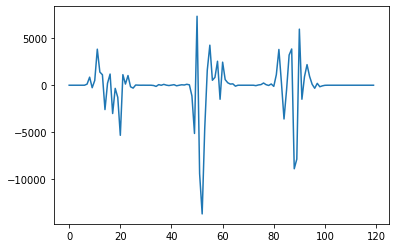

In [94]:
plt.plot(sound)
plt.show()

In [95]:
sound1 = sound[:S1]
sound1

array([    0,     0,     0,     0,     0,     0,     0,   117,   861,
        -268,   509,  3850,  1405,  1119, -2602,   213,  1192, -3022,
        -337, -1292, -5351,  1128,   123,  1034,  -167,  -309,    22,
           7,     0,     3,     0,    -1,     0,   -30,  -128])

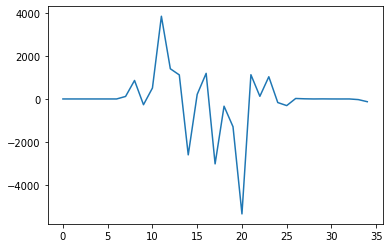

In [96]:
plt.plot(sound1)
plt.show()

In [0]:
sound2 = sound[S1:S2]

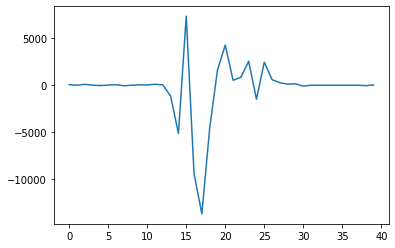

In [98]:
plt.plot(sound2)
plt.show()

In [0]:
sound3 = sound[S2:]

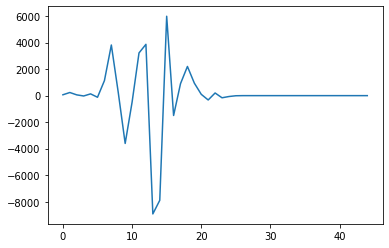

In [100]:
plt.plot(sound3)
plt.show()



---





---



# Переносим точки разрыва на полноценный аудиопоток 
Директорий /content/Simple-Audio-Recognition/Audio_streams/

In [0]:
import os
import numpy as np
import keras
import math
from keras.models import load_model
from scipy.io import wavfile
from scipy.fftpack import dct
from scipy.io import wavfile
import scipy.io.wavfile
import matplotlib.pyplot as plt

In [102]:
#__________для ПОТОКА - файлы для директория  Seg_audio_streams
#sample_file ='no_bed_bird.wav'
#sample_file ='no_bed_bird.wav'
#dir_path = '/content/Simple-Audio-Recognition/Audio_streams/' #  откуда файл берется

#создаем директорий для фразы
dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]
#dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file

if not os.path.exists('/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]): #Если пути не существует создаем его
   dir_path_mod = os.makedirs('/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4])
   dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]
print(sample_file)
print(dir_path)
print(dir_path_mod)


bed_bird_right.wav
/content/Simple-Audio-Recognition/Audio_streams/
/content/Simple-Audio-Recognition/Words_from_streams/bed_bird_right


Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 13600
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=13600, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/bed_bird_right/1_bed_bird_right.wav
16000
[0 0 0 ... 0 0 0]
sound durantion =  0.85


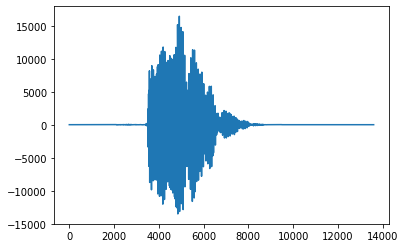

In [103]:
k0 = 0
k1 = 1000*34/40
k2 = 1000*70/40


#+++++++++++++++++++11111111111111111111111111111111111
start = 0
end = k1
x = '1_'

from pydub import silence, AudioSegment

audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)

segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file


obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()




Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 14400
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=14400, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/bed_bird_right/2_bed_bird_right.wav
16000
[0 0 0 ... 0 0 0]
sound durantion =  0.9


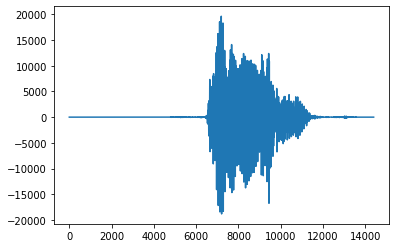

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 20000
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=20000, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/bed_bird_right/3_bed_bird_right.wav
16000
[ 0 -2  0 ...  0  0  0]
sound durantion =  1.25


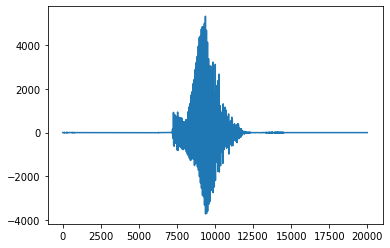

In [104]:

#+++++++++++++++++++22222222222222222222222222
start = k1
end = k2
x = '2_'

from pydub import silence, AudioSegment
audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)
segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file

obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()

#+++++++++++++++++++3333333333333333333333333333
k3 = 3000
start = k2
end = k3
x = '3_'

from pydub import silence, AudioSegment
audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)
segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file

obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()


В результате:
1. Создали директорий по названию фразы (/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/)
2. Разделили первоначальную фразу (неотформатированную) на части. Части поместили в директорий (/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/1_no_bed_bird.wav + 2_no_bed_bird.wav +3_no_bed_bird.wav).
3. Эти полученные слова - сырые. у них нестандартная длина и dataframe может быть не равным 16000. Поэтому перед тем, как скармливать их модели, слова нужно заново обработать. 
4. Обрабатываем слова вырезанные из фразы ноутбуком Директорий of Audio_Preparation.ipynb.  Он обрабатывает все файлы в директории. Сохраняем обработанные файлы в этом же директории.  



---



---





---



---

